In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
from collections import defaultdict
from time import time

# from datetime import datetime
import numpy as np
import pandas as pd
import pandas_datareader.data as web
from logbook import Logger, StderrHandler, INFO

import matplotlib.pyplot as plt
import seaborn as sns

from zipline import run_algorithm
from zipline.api import (attach_pipeline,
                         pipeline_output,
                         date_rules,
                         time_rules,
                         record,
                         schedule_function,
                         commission,
                         slippage,
                         set_slippage,
                         set_commission,
                         order_target,
                         order_target_percent)
from zipline.data import bundles
from zipline.utils.run_algo import load_extensions
from zipline.pipeline import Pipeline, CustomFactor
from zipline.pipeline.data import Column, DataSet
from zipline.pipeline.domain import US_EQUITIES
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.loaders.frame import DataFrameLoader

import pyfolio as pf
from pyfolio.plotting import plot_rolling_returns, plot_rolling_sharpe
from pyfolio.timeseries import forecast_cone_bootstrap

import empyrical as ep

In [3]:
sns.set_style('whitegrid')
pd.set_option('display.expand_frame_repr', False)
np.random.seed(42)

In [4]:
# Load zipline extensions - Only need this in notebook to find bundle.
load_extensions(default=True,
                extensions=[],
                strict=True,
                environ=None)

In [5]:
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('Algorithm')


In [6]:
# Algo Params
N_LONGS = 20
N_SHORTS = 20
MIN_POSITIONS = 10

In [7]:
# Load Data
bundle_data = bundles.load('quandl')

In [8]:
# ML Predictions - We load our predictions for the 2015-17 period and extract the Zipline IDs for the ~250 stocks in our 
# universe for this period.
def load_predictions(bundle):
    predictions = pd.read_hdf('/Volumes/My Book/Data_Analysis/Data/backtest.h5', 'data')[['predicted']].dropna()
    tickers = predictions.index.get_level_values(0).unique().tolist()

    assets = bundle.asset_finder.lookup_symbols(tickers, as_of_date=None)
    # VL applied a fix to the below line due to pd.Int64Index being deprecated. Original line of code was:
    # predicted_sids = pd.Int64Index([asset.sid for asset in assets])
    predicted_sids = pd.Index([asset.sid for asset in assets])
    ticker_map = dict(zip(tickers, predicted_sids))
    return (predictions
            .unstack('ticker')
            .rename(columns=ticker_map)
            .predicted
            # .tz_localize('UTC')), assets
            .tz_localize(None)), assets

In [9]:
predictions, assets = load_predictions(bundle_data)

In [10]:
# Define custom dataset
class SignalData(DataSet):
    predictions = Column(dtype=float)
    domain = US_EQUITIES

In [11]:
# Define pipeline loaders - While the bundle’s OHLCV data can rely on the built-in USEquityPricingLoader, we need 
# to define our own zipline.pipeline.loaders.frame.DataFrameLoader. In fact, we need to slightly modify the Zipline 
# library’s source code to bypass the assumption that we will only load price data. To this end, we will add a 
# custom_loader parameter to the run_algorithm and ensure that this loader is used when the Pipeline needs one of 
# SignalData’s Column instances.

signal_loader = {SignalData.predictions: DataFrameLoader(SignalData.predictions, 
                                                         predictions)}

In [12]:
# Pipeline Setup - have two Boolean columns that identify the assets we would like to trade as long and short positions
# Custome ML Factor - receives the current SignalData.predictions. rank and filter securities.

class MLSignal(CustomFactor):
    """Converting signals to Factor
        so we can rank and filter in Pipeline"""
    inputs = [SignalData.predictions]
    window_length = 1

    def compute(self, today, assets, out, preds):
        out[:] = preds

In [13]:
# Create Pipeline - returns a zipline.pipeline.Pipeline which filters the assets that meet our long/short criteria. 
# We will call ths function periodically while executing the backtest.

def compute_signals():
    signals = MLSignal()
#     predictions = SignalData.predictions.latest
    return Pipeline(columns={
        'longs' : signals.top(N_LONGS, mask=signals > 0),
        'shorts': signals.bottom(N_SHORTS, mask=signals < 0)},
            screen=StaticAssets(assets)
    )

In [14]:
# Initialize Algorithm - It permits us to add entries to the context dictionary available to all backtest components, 
# set parameters like commission and slippage, and schedule functions. 
def initialize(context):
    """
    Called once at the start of the algorithm.
    """
    context.n_longs = N_LONGS
    context.n_shorts = N_SHORTS
    context.min_positions = MIN_POSITIONS
    context.universe = assets

    set_slippage(slippage.FixedSlippage(spread=0.00))
    set_commission(commission.PerShare(cost=0, min_trade_cost=0))

    schedule_function(rebalance,
                      date_rules.every_day(),
                      time_rules.market_open(hours=1, minutes=30))

    schedule_function(record_vars,
                      date_rules.every_day(),
                      time_rules.market_close())

    pipeline = compute_signals()
    attach_pipeline(pipeline, 'signals')

In [15]:
# Get daily pipeline results - Call the below function every day before market opens and we use it to obtain the  
# current pipeline values, i.e., the assets suggested for long and short positions based on the ML model predictions:

def before_trading_start(context, data):
    """
    Called every day before market open.
    """
    output = pipeline_output('signals')
    context.trades = (pd.concat([output['longs'].astype(int),
                      (output['shorts'].astype(int).mul(-1))])
                      .reset_index()
                      .drop_duplicates()
                      .set_index('index')
                      .squeeze())

In [16]:
# Define Rebalancing Logic - This function takes care of adjusting the portfolio positions to reflect the target 
# long and short positions implied by the model forecasets:

def rebalance(context, data):
    """
    Execute orders according to schedule_function() date & time rules.
    """
    trades = defaultdict(list)

    for stock, trade in context.trades.items():
        if not trade:
            order_target(stock, 0)
        else:
            trades[trade].append(stock)
    context.longs, context.shorts = len(trades[1]), len(trades[-1])
    if context.longs > context.min_positions and context.shorts > context.min_positions:
        for stock in trades[-1]:
            order_target_percent(stock, -1 / context.shorts)
        for stock in trades[1]:
            order_target_percent(stock, 1 / context.longs)


In [17]:
# Record Data Points - The record_vars() logs information to the pd.DataFrame returned by run_algorithm() as scheduled.

def record_vars(context, data):
    """
    Plot variables at the end of each day.
    """
    record(leverage=context.account.leverage,
           longs=context.longs,
           shorts=context.shorts)

In [18]:
# Run Algorithm - call run_algorithm() with the desired start and end dates, references to the various functions we 
# just created, and the custom_loader to ensure our model predictions are available to the backtest.

dates = predictions.index.get_level_values('date')
start_date = dates.min()
end_date = (dates.max() + pd.DateOffset(1))

# VL Added the below 2 lines to remove timezone else it was causing trouble later.
# start_date = start_date.replace(tzinfo=None)
# end_date = end_date.replace(tzinfo=None)

In [19]:
start_date, end_date


(Timestamp('2014-12-09 00:00:00'), Timestamp('2017-11-30 00:00:00'))

In [20]:
start = time()
results = run_algorithm(start=start_date,
                       end=end_date,
                       initialize=initialize,
                       before_trading_start=before_trading_start,
                       capital_base=1e6,
                       data_frequency='daily',
                       bundle='quandl',
                       custom_loader=signal_loader) # need to modify zipline

print('Duration: {:.2f}s'.format(time() - start))

Duration: 139.79s


In [21]:
# Performance Analysis with PyFolio
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

# VL added the below line to change the index from datetime to date. This allows matching the index with Benchmark and enables plotting.
# returns.index = returns.index.tz_convert(None)
# returns = returns.to_frame()
# returns['date'] = returns.index.date
# returns = returns.reset_index().drop('index', axis=1)
# returns.set_index('date', inplace=True)

In [22]:
benchmark = web.DataReader('SP500', 'fred', '2014', '2018').squeeze()
benchmark = benchmark.pct_change().tz_localize('UTC')

# benchmark.index = benchmark.index.tz_localize('UTC')
# benchmark.index.name = None
# benchmark.index = benchmark.index.tz_convert(None)
# benchmark = benchmark.to_frame()
# benchmark['date'] = benchmark.index.date
# benchmark = benchmark.reset_index().drop('index', axis=1)
# benchmark.set_index('date', inplace=True)

In [23]:
LIVE_DATE = '2017-01-01'

# LIVE_DATE = pd.Timestamp(ts_input = LIVE_DATE)
# LIVE_DATE = LIVE_DATE.tz_localize(None)

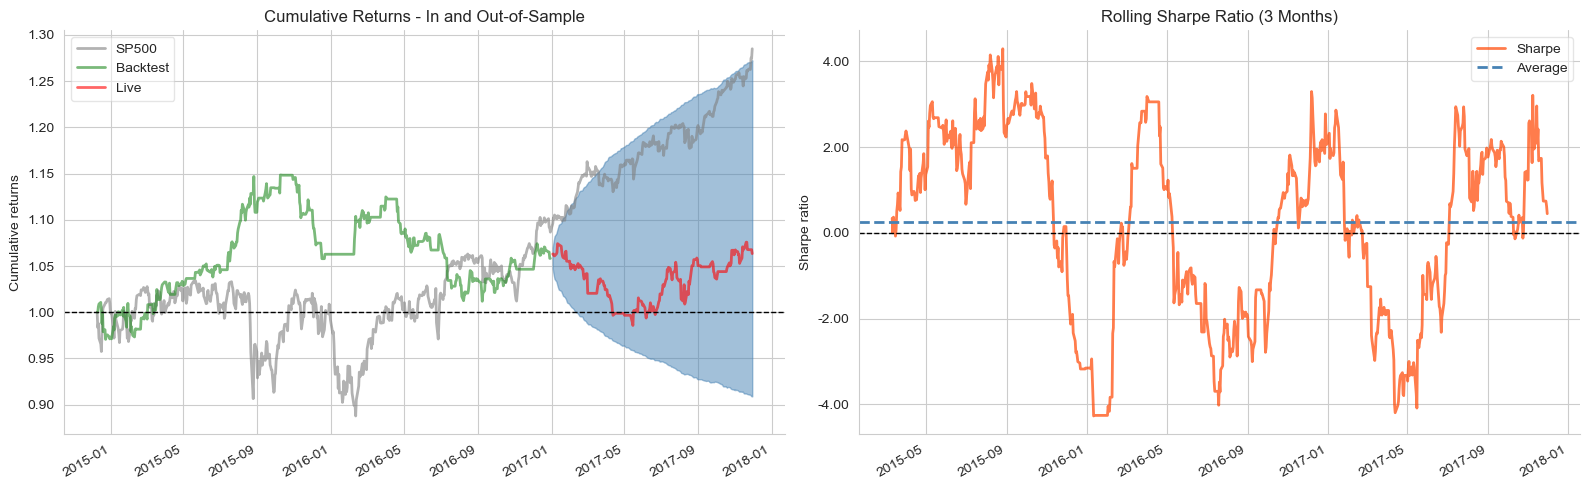

In [24]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 5))
plot_rolling_returns(returns,
                     factor_returns=benchmark,
                     live_start_date=LIVE_DATE,
                     logy=False,
                     cone_std=2,
                     legend_loc='best',
                     volatility_match=False,
                     cone_function=forecast_cone_bootstrap,
                    ax=axes[0])
plot_rolling_sharpe(returns, ax=axes[1], rolling_window=63)
axes[0].set_title('Cumulative Returns - In and Out-of-Sample')
axes[1].set_title('Rolling Sharpe Ratio (3 Months)')
sns.despine()
fig.tight_layout();

Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,14.18,2015-10-09,2017-05-16,NaT,NaN
1,3.96,2014-12-15,2014-12-23,2015-03-18,68
2,3.38,2015-08-26,2015-08-31,2015-10-09,33
3,1.55,2015-08-07,2015-08-12,2015-08-19,9
4,1.35,2015-06-08,2015-06-19,2015-07-14,27


Stress Events,mean,min,max
Fall2015,0.07%,-2.52%,1.58%
New Normal,0.01%,-2.52%,1.90%


Top 10 long positions of all time,max
sid,
AAOI,21.70%
AMD,19.54%
ADBE,17.73%
DG,15.81%
CRM,14.99%
WBA,14.16%
COP,14.16%
JNJ,13.79%
HCA,12.78%


Top 10 short positions of all time,max
sid,
ADBE,-22.66%
AAOI,-18.13%
DOW,-16.25%
PANW,-15.12%
WMB,-15.02%
SWKS,-14.60%
AVGO,-14.51%
AMD,-14.48%
INCY,-14.47%


Top 10 positions of all time,max
sid,
ADBE,22.66%
AAOI,21.70%
AMD,19.54%
DOW,16.25%
DG,15.81%
PANW,15.12%
WMB,15.02%
CRM,14.99%
SWKS,14.60%


Summary stats,All trades,Short trades,Long trades
Total number of round_trips,19072.00,9267.00,9805.00
Percent profitable,0.50,0.49,0.50
Winning round_trips,9451.00,4512.00,4939.00
Losing round_trips,9478.00,4691.00,4787.00
Even round_trips,143.00,64.00,79.00


PnL stats,All trades,Short trades,Long trades
Total profit,$90985.88,$-153674.51,$244660.39
Gross profit,$4300765.63,$2074951.62,$2225814.00
Gross loss,$-4209779.74,$-2228626.13,$-1981153.62
Profit factor,$1.02,$0.93,$1.12
Avg. trade net profit,$4.77,$-16.58,$24.95
Avg. winning trade,$455.06,$459.87,$450.66
Avg. losing trade,$-444.16,$-475.09,$-413.86
Ratio Avg. Win:Avg. Loss,$1.02,$0.97,$1.09
Largest winning trade,$48243.75,$48243.75,$10265.64
Largest losing trade,$-18431.28,$-13113.79,$-18431.28


Duration stats,All trades,Short trades,Long trades
Avg duration,1 days 11:38:13.792103607,1 days 10:41:59.262220783,1 days 12:31:23.161652218
Median duration,1 days 00:00:00,1 days 00:00:00,1 days 00:00:00
Longest duration,138 days 00:00:00,5 days 03:00:00,138 days 00:00:00
Shortest duration,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00


Return stats,All trades,Short trades,Long trades
Avg returns all round_trips,0.00%,-0.00%,0.00%
Avg returns winning,0.04%,0.04%,0.04%
Avg returns losing,-0.04%,-0.04%,-0.04%
Median returns all round_trips,0.00%,-0.00%,0.00%
Median returns winning,0.02%,0.02%,0.02%
Median returns losing,-0.02%,-0.02%,-0.02%
Largest winning trade,4.61%,4.61%,1.02%
Largest losing trade,-1.78%,-1.14%,-1.78%


Symbol stats,AAL,AAOI,AAP,AAPL,ABBV,ABT,ACN,ADBE,ADI,ADP,ADSK,AIG,ALTR,AMAT,AMBA,AMD,AMGN,AMT,AMZN,APA,APD,AVGO,AXP,AZO,BA,BAC,BAX,BBY,BDX,BIDU,BIIB,BK,BLK,BMY,BP,BSX,C,CAT,CB,CCI,CCL,CHK,CHTR,CI,CL,CLF,CMCSA,CMG,CMI,CNC,COF,COP,COST,COTY,CRM,CSCO,CSX,CTSH,CVS,CVX,DAL,DD,DE,DFS,DG,DHR,DIS,DLR,DLTR,DOW,DUK,DVN,EA,EBAY,EFX,EL,EMR,EOG,EQIX,EQT,EW,EXPE,F,FCX,FDX,FL,FLT,FOXA,FTI,GE,GILD,GIS,GM,GOOG,GOOGL,GPN,GS,GWW,HAL,HCA,HD,HES,HON,HPE,HPQ,HSY,HTZ,HUM,IBM,ILMN,INCY,INTC,INTU,ISRG,JCI,JNJ,JPM,JWN,K,KHC,KMB,KMI,KO,KR,KSS,LDOS,LL,LLY,LMT,LNG,LOW,LRCX,LUV,LVS,LYB,M,MA,MAR,MAT,MCD,MCHP,MCK,MDLZ,MDT,MET,MGM,MMM,MNST,MO,MPC,MRK,MRO,MS,MSFT,MU,NEE,NEM,NFLX,NKE,NOC,NOV,NSC,NVDA,NWL,OKE,ORCL,ORLY,OXY,PANW,PCG,PEP,PFE,PG,PLL,PM,PNC,PRGO,PRU,PSX,PXD,PYPL,QCOM,RCL,REGN,RF,RIG,SBAC,SBUX,SCHW,SDRL,SE,SHW,SIG,SLB,SO,SPG,SRPT,STZ,SWKS,SWN,SYF,SYY,T,TAP,TDG,TGT,TJX,TMO,TMUS,TSLA,TSN,TXN,UAA,UAL,ULTA,UNH,UNP,UPS,URI,USB,V,VLO,VRTX,WBA,WDC,WFC,WMB,WMT,WOOF,WYNN,X,XOM,YUM
Avg returns all round_trips,-0.00%,-0.08%,0.00%,-0.01%,-0.00%,-0.00%,-0.00%,0.01%,0.01%,0.04%,0.04%,-0.00%,-0.02%,0.00%,0.03%,0.01%,-0.00%,0.01%,0.00%,-0.01%,0.00%,-0.00%,0.00%,-0.02%,-0.00%,-0.00%,-0.01%,0.01%,0.00%,0.01%,-0.01%,-0.01%,-0.02%,-0.00%,-0.02%,-0.15%,-0.00%,-0.00%,-0.01%,-0.02%,0.03%,-0.02%,-0.01%,-0.01%,0.01%,-0.02%,0.00%,0.01%,0.01%,0.05%,0.01%,-0.00%,-0.00%,0.02%,0.00%,0.01%,0.00%,0.01%,0.00%,0.00%,0.01%,0.00%,-0.00%,0.00%,-0.02%,0.00%,-0.00%,-0.05%,0.02%,-0.00%,0.02%,0.01%,-0.00%,-0.00%,0.00%,0.00%,0.01%,-0.00%,0.01%,-0.02%,NaN,0.03%,0.00%,0.00%,0.02%,0.01%,0.07%,0.01%,-0.01%,-0.00%,0.01%,0.02%,-0.00%,0.01%,0.01%,0.03%,-0.00%,0.01%,0.00%,0.01%,0.00%,0.01%,0.01%,-0.02%,-0.17%,0.01%,-0.01%,-0.00%,-0.00%,0.01%,0.01%,0.00%,-0.01%,0.01%,-0.01%,-0.00%,-0.00%,0.00%,-0.00%,-0.01%,0.00%,0.00%,0.00%,0.02%,-0.03%,-0.01%,0.03%,-0.00%,-0.00%,0.16%,0.00%,-0.01%,0.00%,-0.01%,-0.01%,0.01%,-0.01%,-0.00%,-0.07%,-0.01%,-0.08%,-0.02%,0.00%,-0.00%,-0.01%,0.02%,-0.00%,0.00%,-0.00%,-0.02%,-0.00%,-0.02%,-0.00%,0.00%,0.00%,0.05%,0.03%,-0.00%,0.01%,0.02%,-0.02%,0.06%,0.01%,-0.01%,0.01%,0.00%,-0.03%,0.00%,0.00%,-0.01%,0.00%,-0.00%,0.00%,-0.00%,-0.00%,-0.01%,0.02%,0.03%,0.02%,-0.00%,-0.01%,0.00%,-0.01%,0.00%,0.02%,0.01%,0.06%,0.00%,0.01%,0.02%,0.01%,0.01%,0.01%,0.01%,-0.00%,-0.00%,0.03%,-0.01%,0.01%,-0.02%,-0.00%,0.00%,-0.00%,-0.01%,0.02%,-0.00%,0.01%,-0.00%,0.00%,0.00%,-0.02%,0.00%,0.02%,0.00%,0.00%,0.00%,-0.00%,0.00%,-0.01%,0.00%,-0.00%,-0.00%,0.00%,0.00%,0.01%,-0.00%,-0.01%,0.00%,-0.00%,-0.01%,-0.01%,0.00%,0.03%
Avg returns winning,0.06%,0.42%,0.16%,0.03%,0.03%,0.03%,0.02%,0.08%,0.08%,0.07%,0.04%,0.02%,0.03%,0.05%,0.14%,0.10%,0.03%,0.03%,0.05%,0.04%,0.00%,0.05%,0.03%,0.04%,0.04%,0.04%,0.02%,0.04%,0.02%,0.07%,0.04%,0.01%,0.01%,0.04%,0.03%,NaN,0.03%,0.04%,0.02%,0.02%,0.06%,0.06%,0.03%,0.02%,0.02%,0.00%,0.03%,0.05%,0.06%,0.07%,0.04%,0.06%,0.02%,0.06%,0.04%,0.04%,0.04%,0.03%,0.04%,0.04%,0.06%,0.05%,0.02%,0.02%,0.03%,0.02%,0.02%,NaN,0.05%,0.04%,0.06%,0.10%,0.04%,0.03%,0.03%,0.00%,0.03%,0.05%,0.05%,0.03%,NaN,0.08%,0.04%,0.11%,0.04%,0.05%,0.10%,0.05%,0.02%,0.03%,0.04%,0.02%,0.04%,0.05%,0.04%,0.07%,0.03%,0.37%,0.05%,0.04%,0.02%,0.11%,0.03%,NaN,0.03%,0.01%,0.03%,0.03%,0.02%,0.07%,0.09%,0.03%,NaN,0.04%,0.03%,0.02%,0.02%,0.07%,0.01%,0.02%,0.00%,0.08%,0.02%,0.11%,0.00%,0.00%,0.17%,0.03%,0.02%,0.30%,0.04%,0.04%,0.07%,0.05%,0.06%,0.05%,0.02%,0.02%,NaN,0.01%,NaN,0.03%,0.04%,0.03%,0.03%,0.08%,0.02%,0.02%,0.02%,0.08%,0.02%,0.10%,0.04%,0.04%,0.07%,0.06%,0.05%,0.06%,0.04%,0.02%,0.06%,0.06%,0.05%,0.03%,0.04%,0.03%,0.03%,0.05%,0.05%,0.02%,0.02%,0.02%,0.02%,0.00%,0.02%,0.03%,0.06%,0.03%,0.08%,0.05%,0.03%,0.05%,0.08%,0.07%,0.04%,0.04%,0.06%,0.03%,0.05%,0.08%,0.04%,0.04%,0.06%,0.04%,0.02%,0.03%,0.12%,0.01%,0.08%,0.05%,0.05%,0.05%,0.02%,0.02%,0.06%,0.03%,0.04%,0.01%,0.03%,0.07%,0.02%,0.03%,0.05%,0.07%,0.04%,0.03%,0.04%,0.02%,0.04%,0.02%,0.03%,0.04%,0.05%,0.04%,0.06%,0.03%,0.05%,0.03%,NaN,0.04%,0.07%,0.03%,0.04%
Avg returns losing,-0.06%,-0.64%,-0.16%,-0.04%,-0.04%,-0.04%,-0.01%,-0.05%,-0.11%,-0.01%,NaN,-0.03%,-0.0

Profitability (PnL / PnL total) per name,
symbol,
CMG,32.10%
KR,28.31%
CSCO,20.13%
MU,19.76%
GILD,19.24%
NVDA,16.98%
BIDU,16.80%
PSX,16.05%
SLB,15.88%


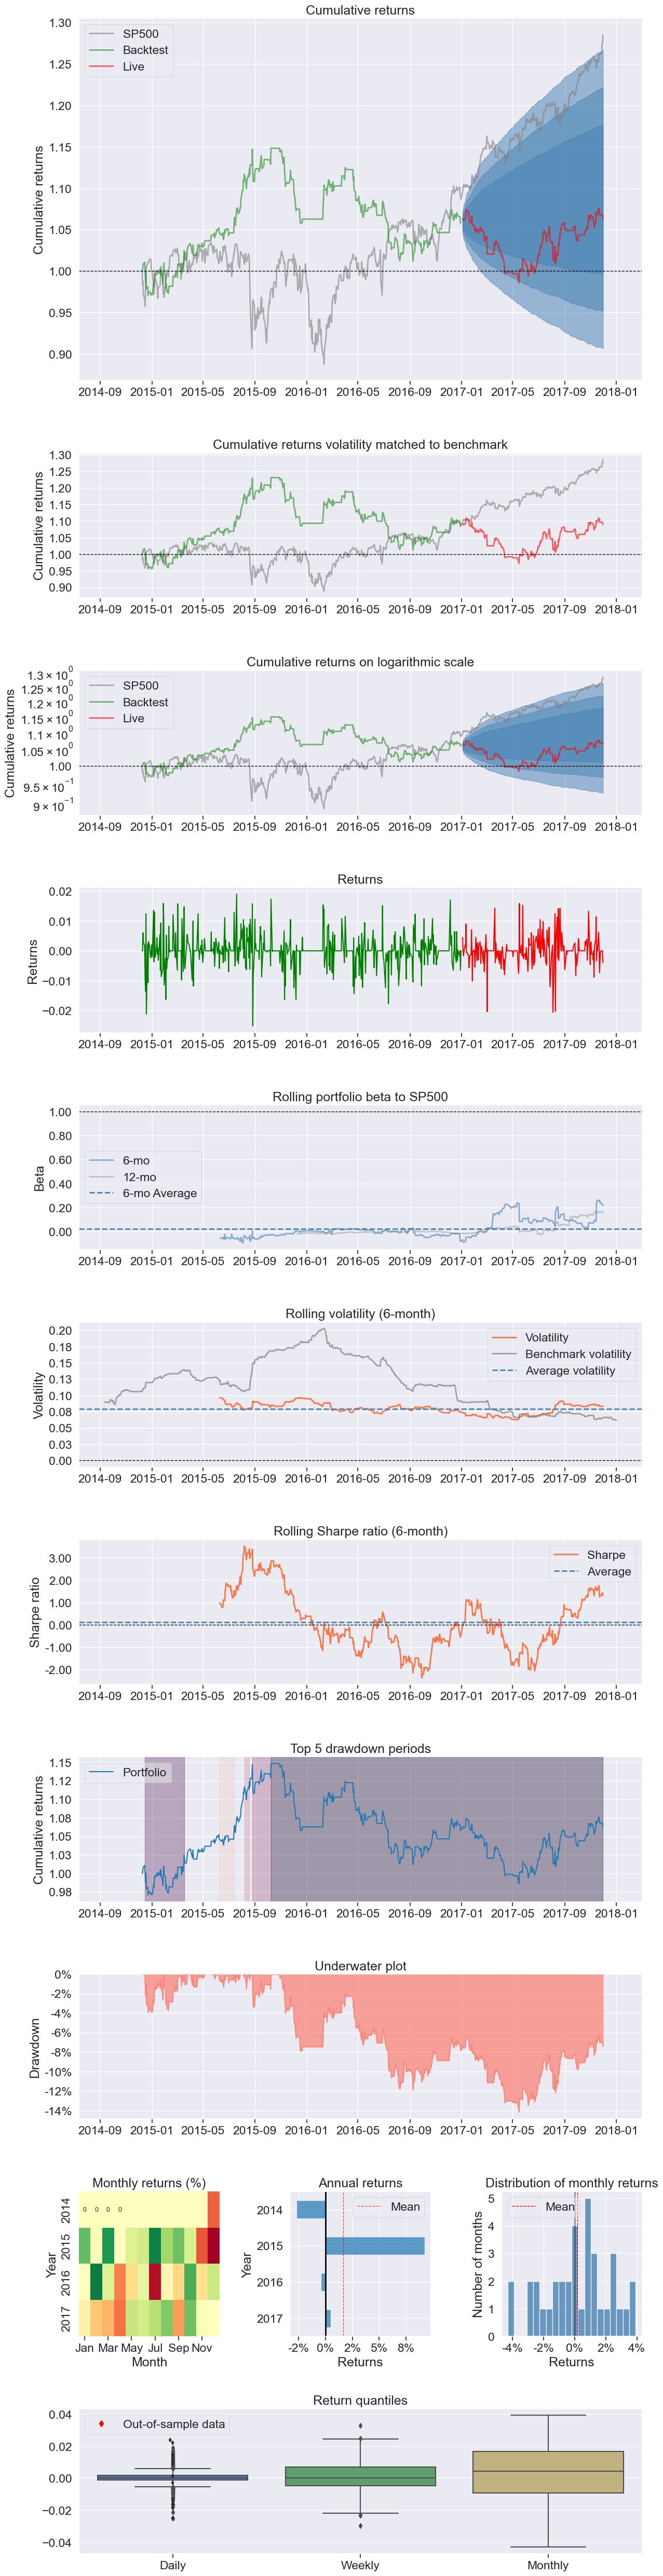

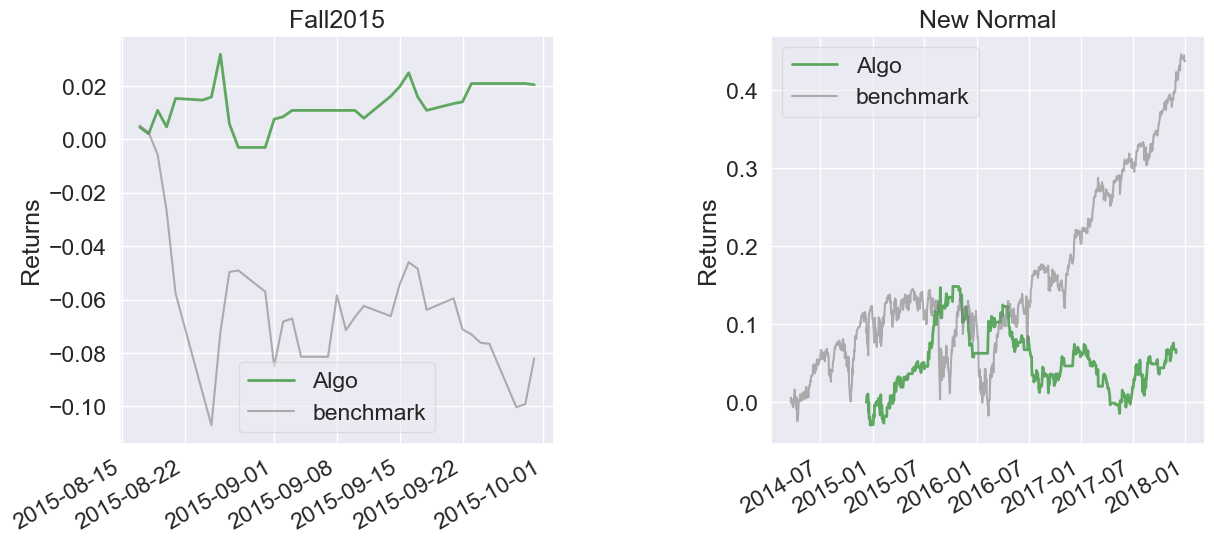

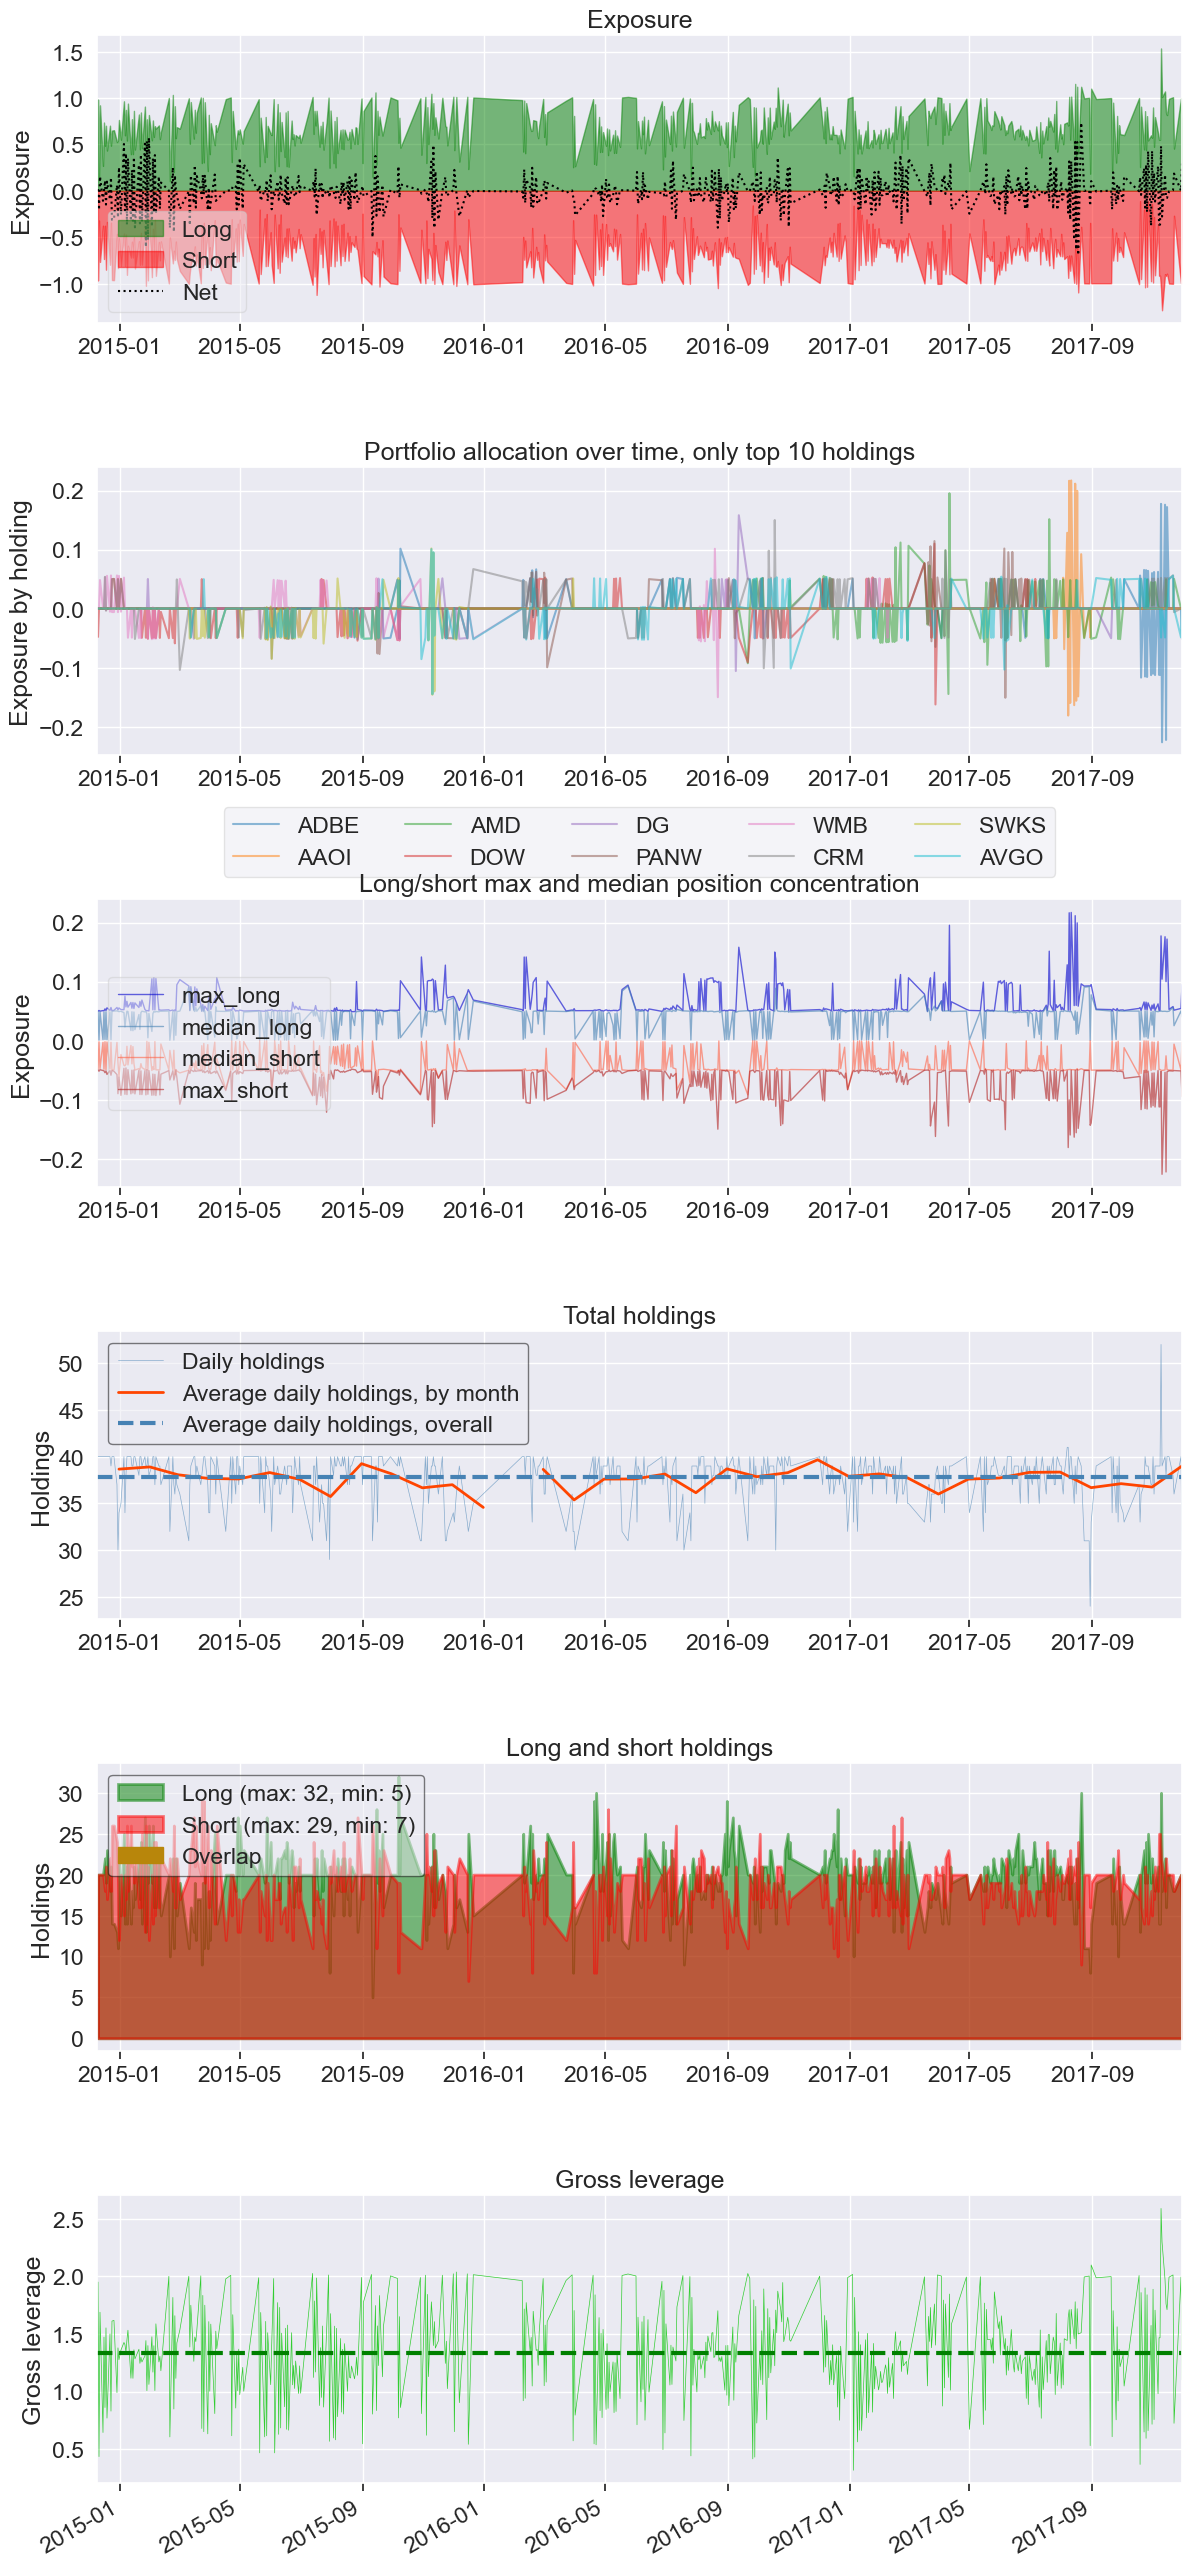

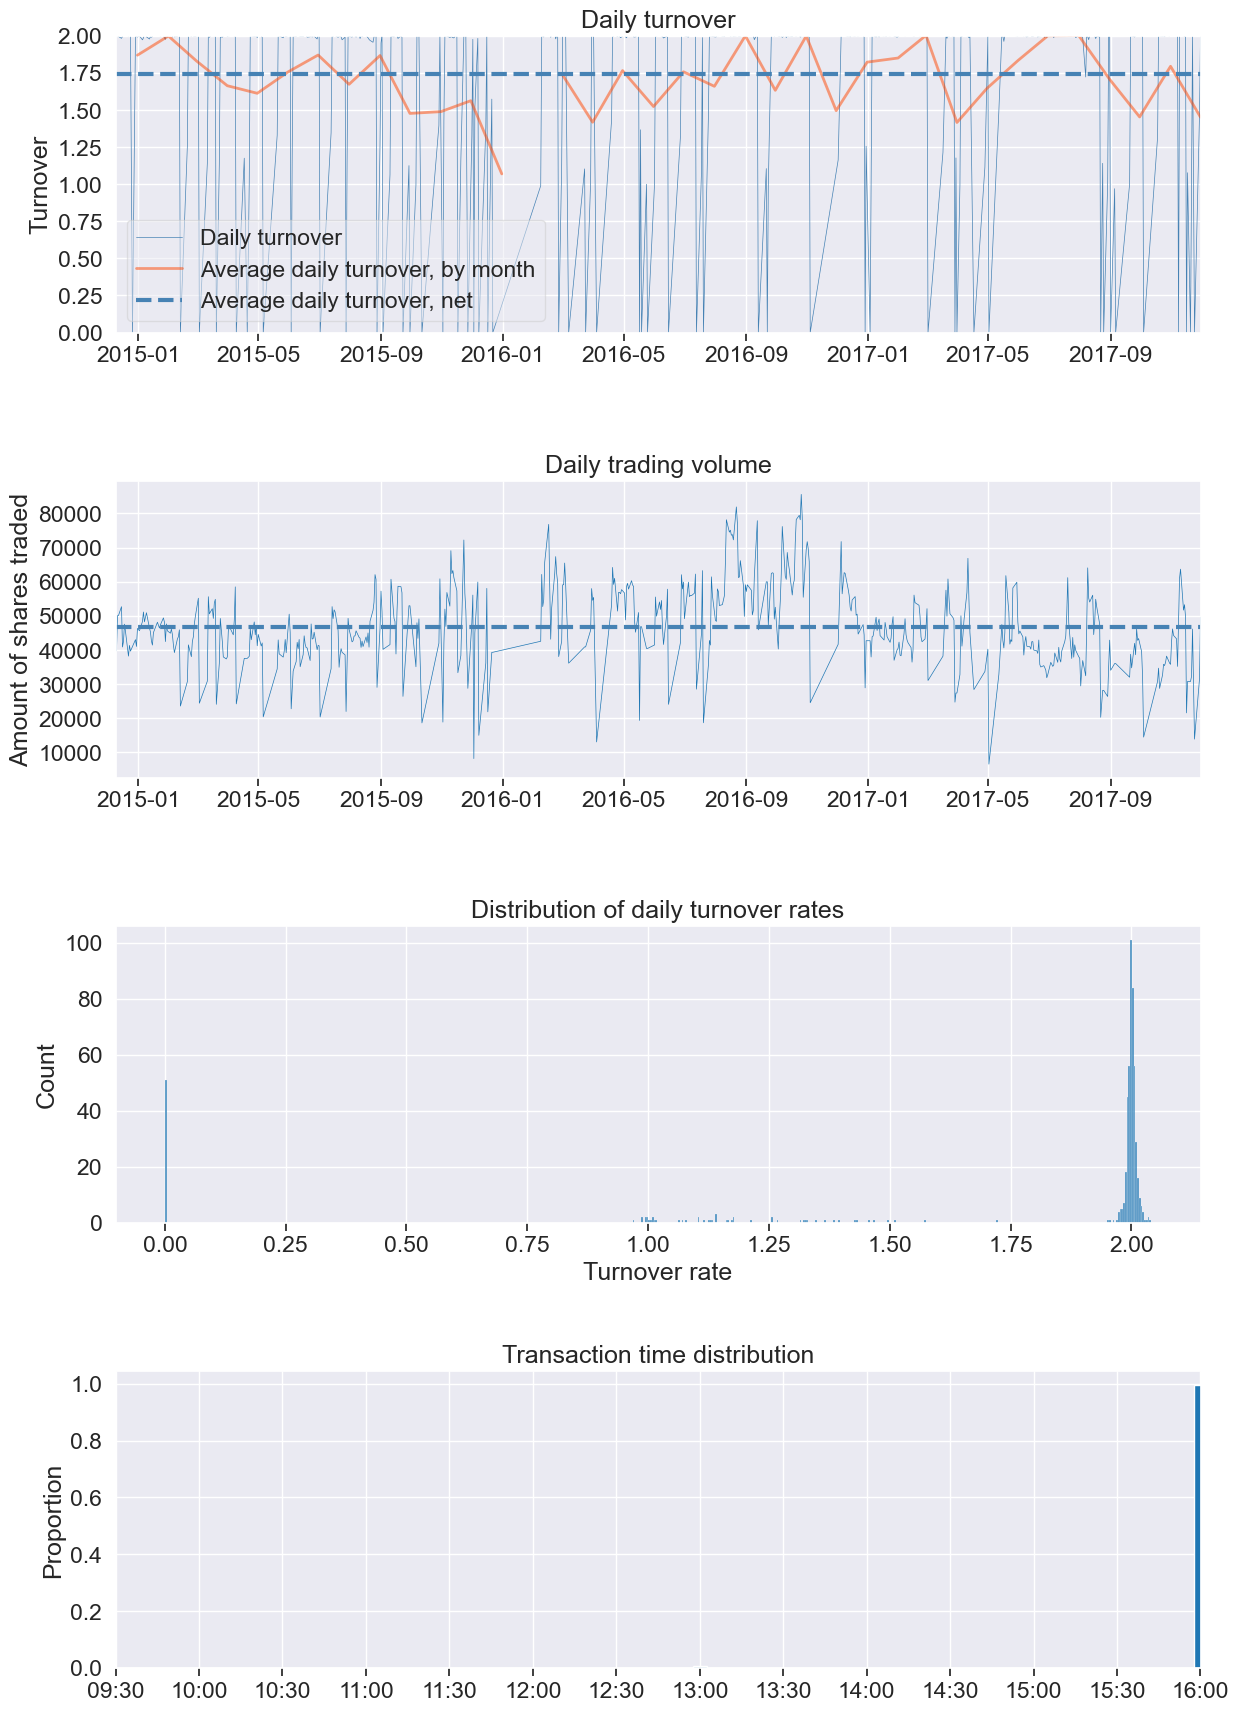

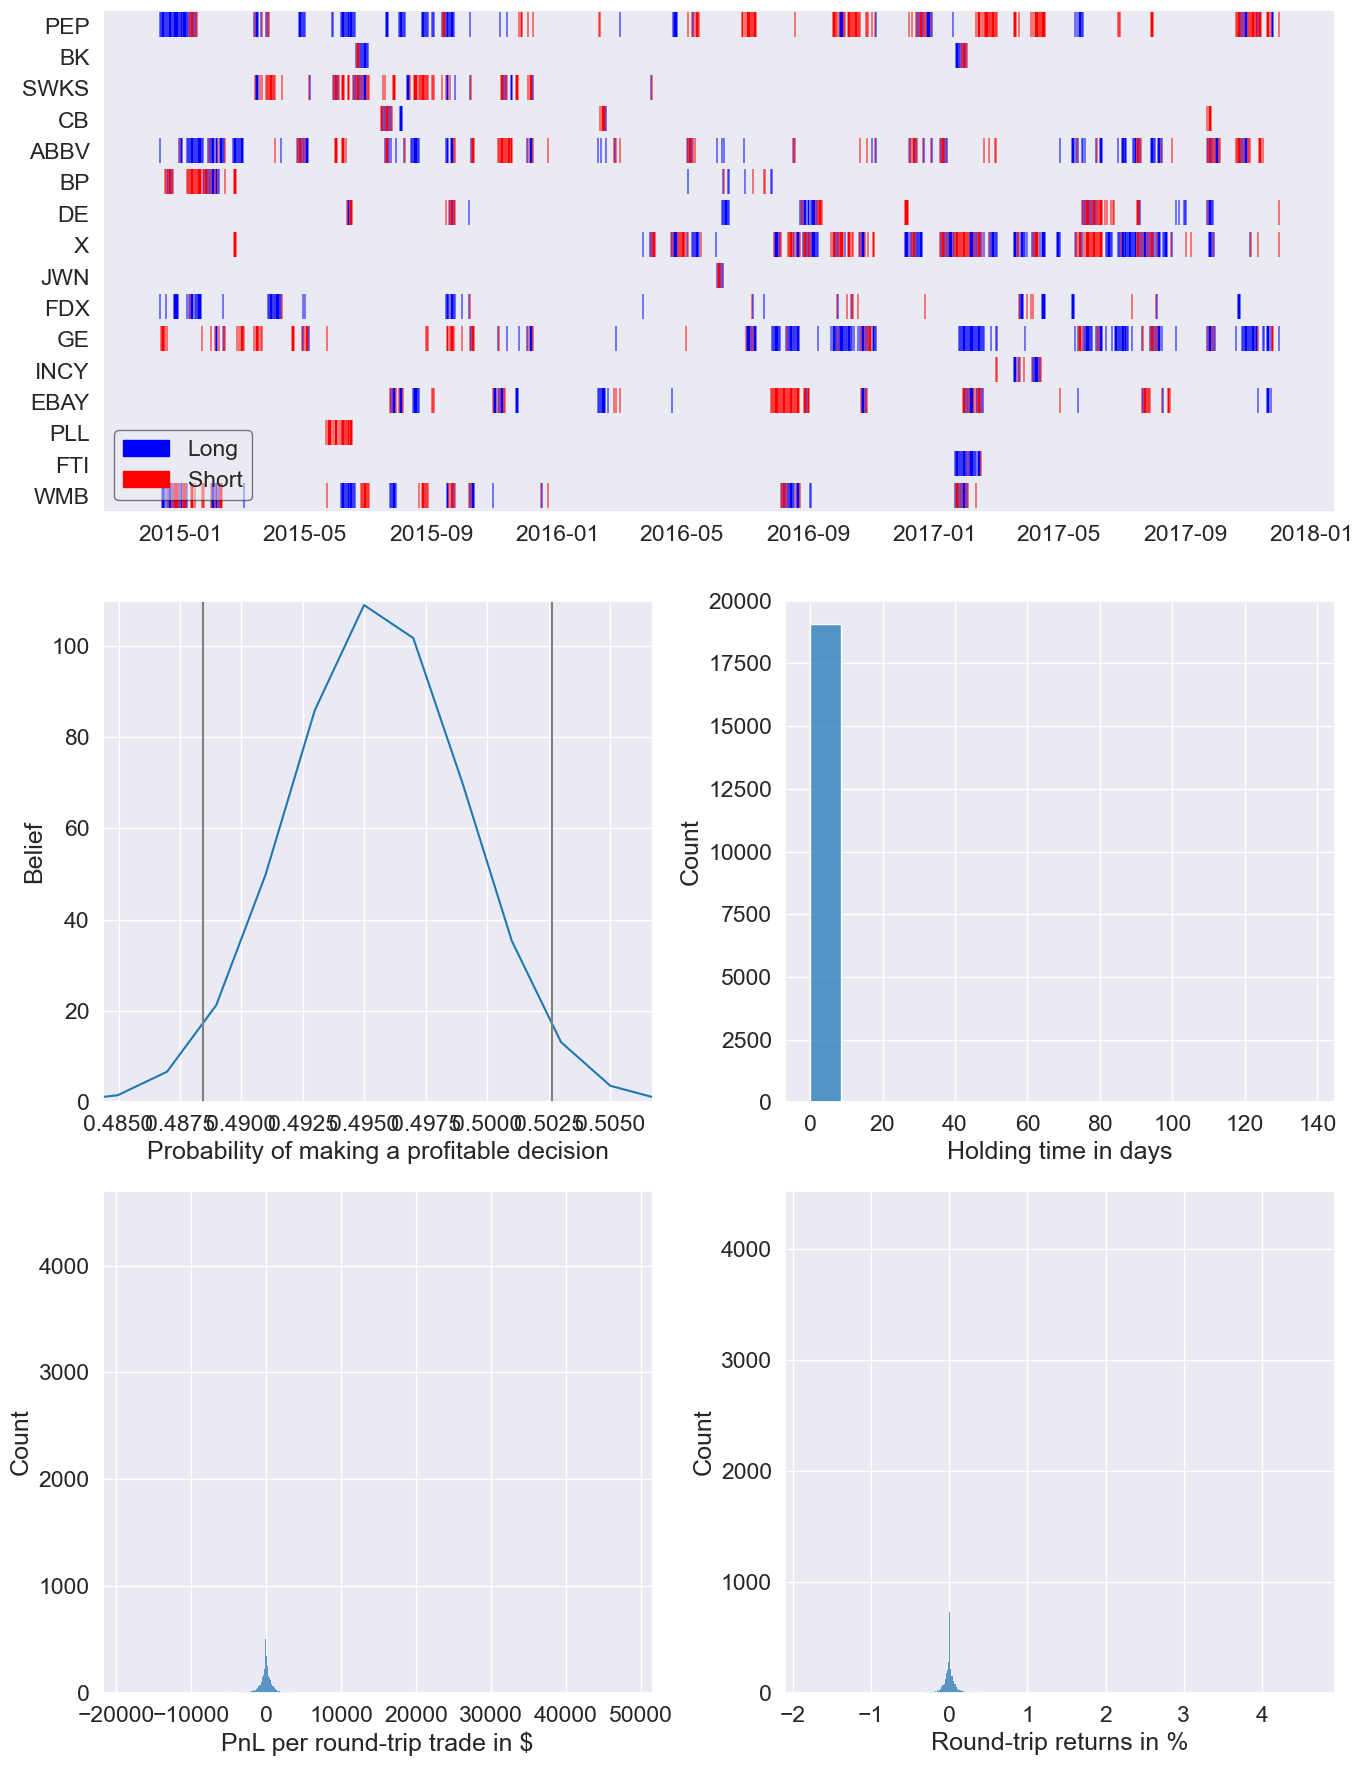

In [25]:
pf.create_full_tear_sheet(returns, 
                          positions=positions, 
                          transactions=transactions,
                          benchmark_rets=benchmark,
                          live_start_date=LIVE_DATE, 
                          round_trips=True)